In [ ]:
import os
import pickle
import csv
import sys

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import scipy.stats as sps

import chippr

%matplotlib inline

# making CosmoLike input

In [ ]:
test_dir = '../results/all_systematics'

In [ ]:
simulated_posteriors = chippr.catalog(params='all_systematics.txt', loc=test_dir)

In [ ]:
data = simulated_posteriors.read(loc='data', style='.txt')

In [ ]:
params = chippr.utils.ingest('all_systematics.txt')
def check_prob_params(params):
    """
    Sets parameter values pertaining to components of probability

    Parameters
    ----------
    params: dict
        dictionary containing key/value pairs for probability

    Returns
    -------
    params: dict
        dictionary containing key/value pairs for probability
    """
    if 'prior_mean' not in params:
        params['prior_mean'] = 'interim'
    else:
        params['prior_mean'] = params['prior_mean'][0]
    if 'no_prior' not in params:
        params['no_prior'] = 0
    else:
        params['no_prior'] = int(params['no_prior'][0])
    if 'no_data' not in params:
        params['no_data'] = 0
    else:
        params['no_data'] = int(params['no_data'][0])
    return params
params = check_prob_params(params)
def set_up_prior(data, params):
    """
    Function to create prior distribution from data

    Parameters
    ----------
    data: dict
        catalog dictionary containing bin endpoints, log interim prior, and log
        interim posteriors
    params: dict
        dictionary of parameter values for creation of prior

    Returns
    -------
    prior: chippr.mvn object
        prior distribution as multivariate normal
    """
    zs = data['bin_ends']
    log_nz_intp = data['log_interim_prior']
    log_z_posts = data['log_interim_posteriors']

    z_difs = zs[1:]-zs[:-1]
    z_mids = (zs[1:]+zs[:-1])/2.
    n_bins = len(z_mids)

    n_pdfs = len(log_z_posts)

    a = 1.# / n_bins
    b = 20.#1. / z_difs ** 2
    c = a / n_pdfs
    prior_var = np.eye(n_bins)
    for k in range(n_bins):
        prior_var[k] = a * np.exp(-0.5 * b * (z_mids[k] - z_mids) ** 2)
    prior_var += c * np.identity(n_bins)

    prior_mean = log_nz_intp
    prior = chippr.mvn(prior_mean, prior_var)
    if params['prior_mean'] == 'sample':
        new_mean = prior.sample_one()
        prior = chippr.mvn(new_mean, prior_var)
        print(params['prior_mean'], prior_mean, new_mean)
    else:
        print(params['prior_mean'], prior_mean)

    return (prior, prior_var)
(prior, cov) = set_up_prior(data, params)

In [ ]:
with open(os.path.join('../results/all_systematics/data', 'true_params.p'), 'r') as true_file:
    true_nz_info = pickle.load(true_file)

In [ ]:
true_funcs = [chippr.discrete(true_nz_info['grid'], true_nz_info['amps'])]
true_amps = [1.]
true_nz = chippr.gmix(true_amps, true_funcs, limits=(min(true_nz_info['bins']), max(true_nz_info['bins'])))
grid_mids = (true_nz_info['grid'][1:] + true_nz_info['grid'][:-1])/2.
plt.plot(grid_mids, true_nz.evaluate(grid_mids))


In [ ]:
nz = chippr.log_z_dens(data, prior, truth=true_nz, loc='../results/all_systematics', vb=True)

In [ ]:
nz.read('nz.p')

In [ ]:
bins_to_write = np.linspace(0.0101, 3.5001, 350)
empty_bins = np.random.random((350, 4))/350.


In [ ]:
bin_mids = (nz.info['bin_ends'][1:] + nz.info['bin_ends'][:-1])/2.
with open(os.path.join('../results/all_systematics/results', 'nz_mmle_test.txt'), 'wb') as cosmolike_file:
#     cosmolike_file.write(zip(bin_mids, np.exp(nz.info['estimators']['log_mmle_nz']))
    cosmolike_writer = csv.writer(cosmolike_file, delimiter=' ')
    cosmolike_writer.writerows(zip(bin_mids, np.exp(nz.info['estimators']['log_mmle_nz'])))

# what to do with CosmoLike output

In [ ]:
covariances = np.zeros((200, 200))#+sys.float_info.epsilon
with open(os.path.join('../results/all_systematics/results', 'Cl_cov.nz_histo.txt'), 'rb') as cosmolike_file:
    cosmolike_reader = csv.reader(cosmolike_file, delimiter=' ')
    cosmolike_reader.next()
    for row in cosmolike_reader:
        covariances[int(row[0])][int(row[1])] = float(row[2])
        covariances[int(row[1])][int(row[0])] = covariances[int(row[0])][int(row[1])]

In [ ]:
plt.imshow(np.log(covariances))
print(covariances)

In [ ]:
invcovariances = np.linalg.pinv(covariances)# / sys.float_info.epsilon) * sys.float_info.epsilon
print(invcovariances)

# invcovariances = np.linalg.pinv(1.e15 * covariances) * 1.e15
# print(invcovariances)

In [ ]:
plt.imshow(np.log(invcovariances * sys.float_info.epsilon))
print(invcovariances * sys.float_info.epsilon)

In [ ]:
# Cl, dCldOm, dClds8, dCldns, dCldw0, dCldwa, dCldOb, dCldH0 = np.zeros(200), np.zeros(200), np.zeros(200), np.zeros(200), np.zeros(200), np.zeros(200), np.zeros(200)
deriv_info = np.zeros((200, 7)
                     )

with open(os.path.join('../results/all_systematics/results', 'Cl_derivs.nz_histo.txt'), 'rb') as cosmolike_file:
    cosmolike_reader = csv.reader(cosmolike_file, delimiter=' ')
    cosmolike_reader.next()
    i = 0
    while i < 200:
        for row in cosmolike_reader:
            for j in range(7):
                deriv_info[i][j] = float(row[j])
        i += 1

In [ ]:
deriv_info = deriv_info.T
dCldOm, dClds8, dCldns, dCldw0, dCldwa, dCldOb, dCldH0 = deriv_info[0], deriv_info[1], deriv_info[2], deriv_info[3], deriv_info[4], deriv_info[5], deriv_info[6]

In [ ]:
ls = np.arange(200)
fisher = np.eye(7)
for i in range(7):
    for j in range(i+1):
        fisher[i][j] = np.sum((2. * ls + 1.) * deriv_info[i] * (invcovariances * sys.float_info.epsilon) * deriv_info[j])
        fisher[j][i] = fisher[i][j]

In [ ]:
print(fisher/sys.float_info.epsilon)
plt.imshow(fisher/sys.float_info.epsilon)

[[ 6085.43700204   189.15494266 -5446.27086117  -723.32132456 -2122.6822711
    761.8376728  -5560.01976124]
 [  261.46383394    21.64002842  -245.22987057   -92.25902418
     64.10184034   -86.07753883  -436.94334229]
 [-5103.64600733  -161.66375912  5990.18244689   -66.53224322
   1728.94782069   412.36696124  2829.41077411]
 [ -468.11428571   -45.99252367  -444.70857143  -474.48584127
    116.47129252  -157.04119728  -834.80380952]
 [-1974.48205128    48.80616182  1905.16512821   294.03678632    67.4164591
    302.34381441   259.7634188 ]
 [  756.18461538   -68.83128767   403.29846154  -199.75876923
    314.47677656   -49.39205861  -331.88102564]
 [-5041.23076923  -318.14219127  2772.67692308  -306.67487179
   -276.06739927   -34.80849817 -1428.34871795]]


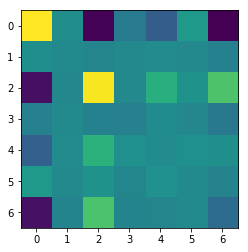

In [28]:
invfisher = np.linalg.inv(fisher/sys.float_info.epsilon) * sys.float_info.epsilon
plt.imshow(invfisher)
print(invfisher)

(1, 0, 3053.5385152313188, 3040.0436856797278, 78.061400198248094, 3.6735309378840149, -0.037088314017537927)
(2, 0, 6037.8097244642095, 5272.3910034234341, 106.34942749205396, 27.666201781971722, 0.78088381660066808)
(2, 1, 3005.9112376535545, 2990.9061223953199, 77.439120346559164, 3.8736436669155028, -0.034033856063757792)
(4, 0, 3076.4267305692165, 3639.4149060921923, 81.950238783431317, 23.727371862955572, 0.29886719667462497)
(4, 1, 44.528243758561672, 60.435380315472834, 10.245175648764373, 3.988375177551776, 0.59280831880508089)
(4, 2, 3028.7994529914522, 3473.2866759008061, 80.63551406726603, 21.082865623756035, -0.27517386169825331)


IndexError: list index out of range

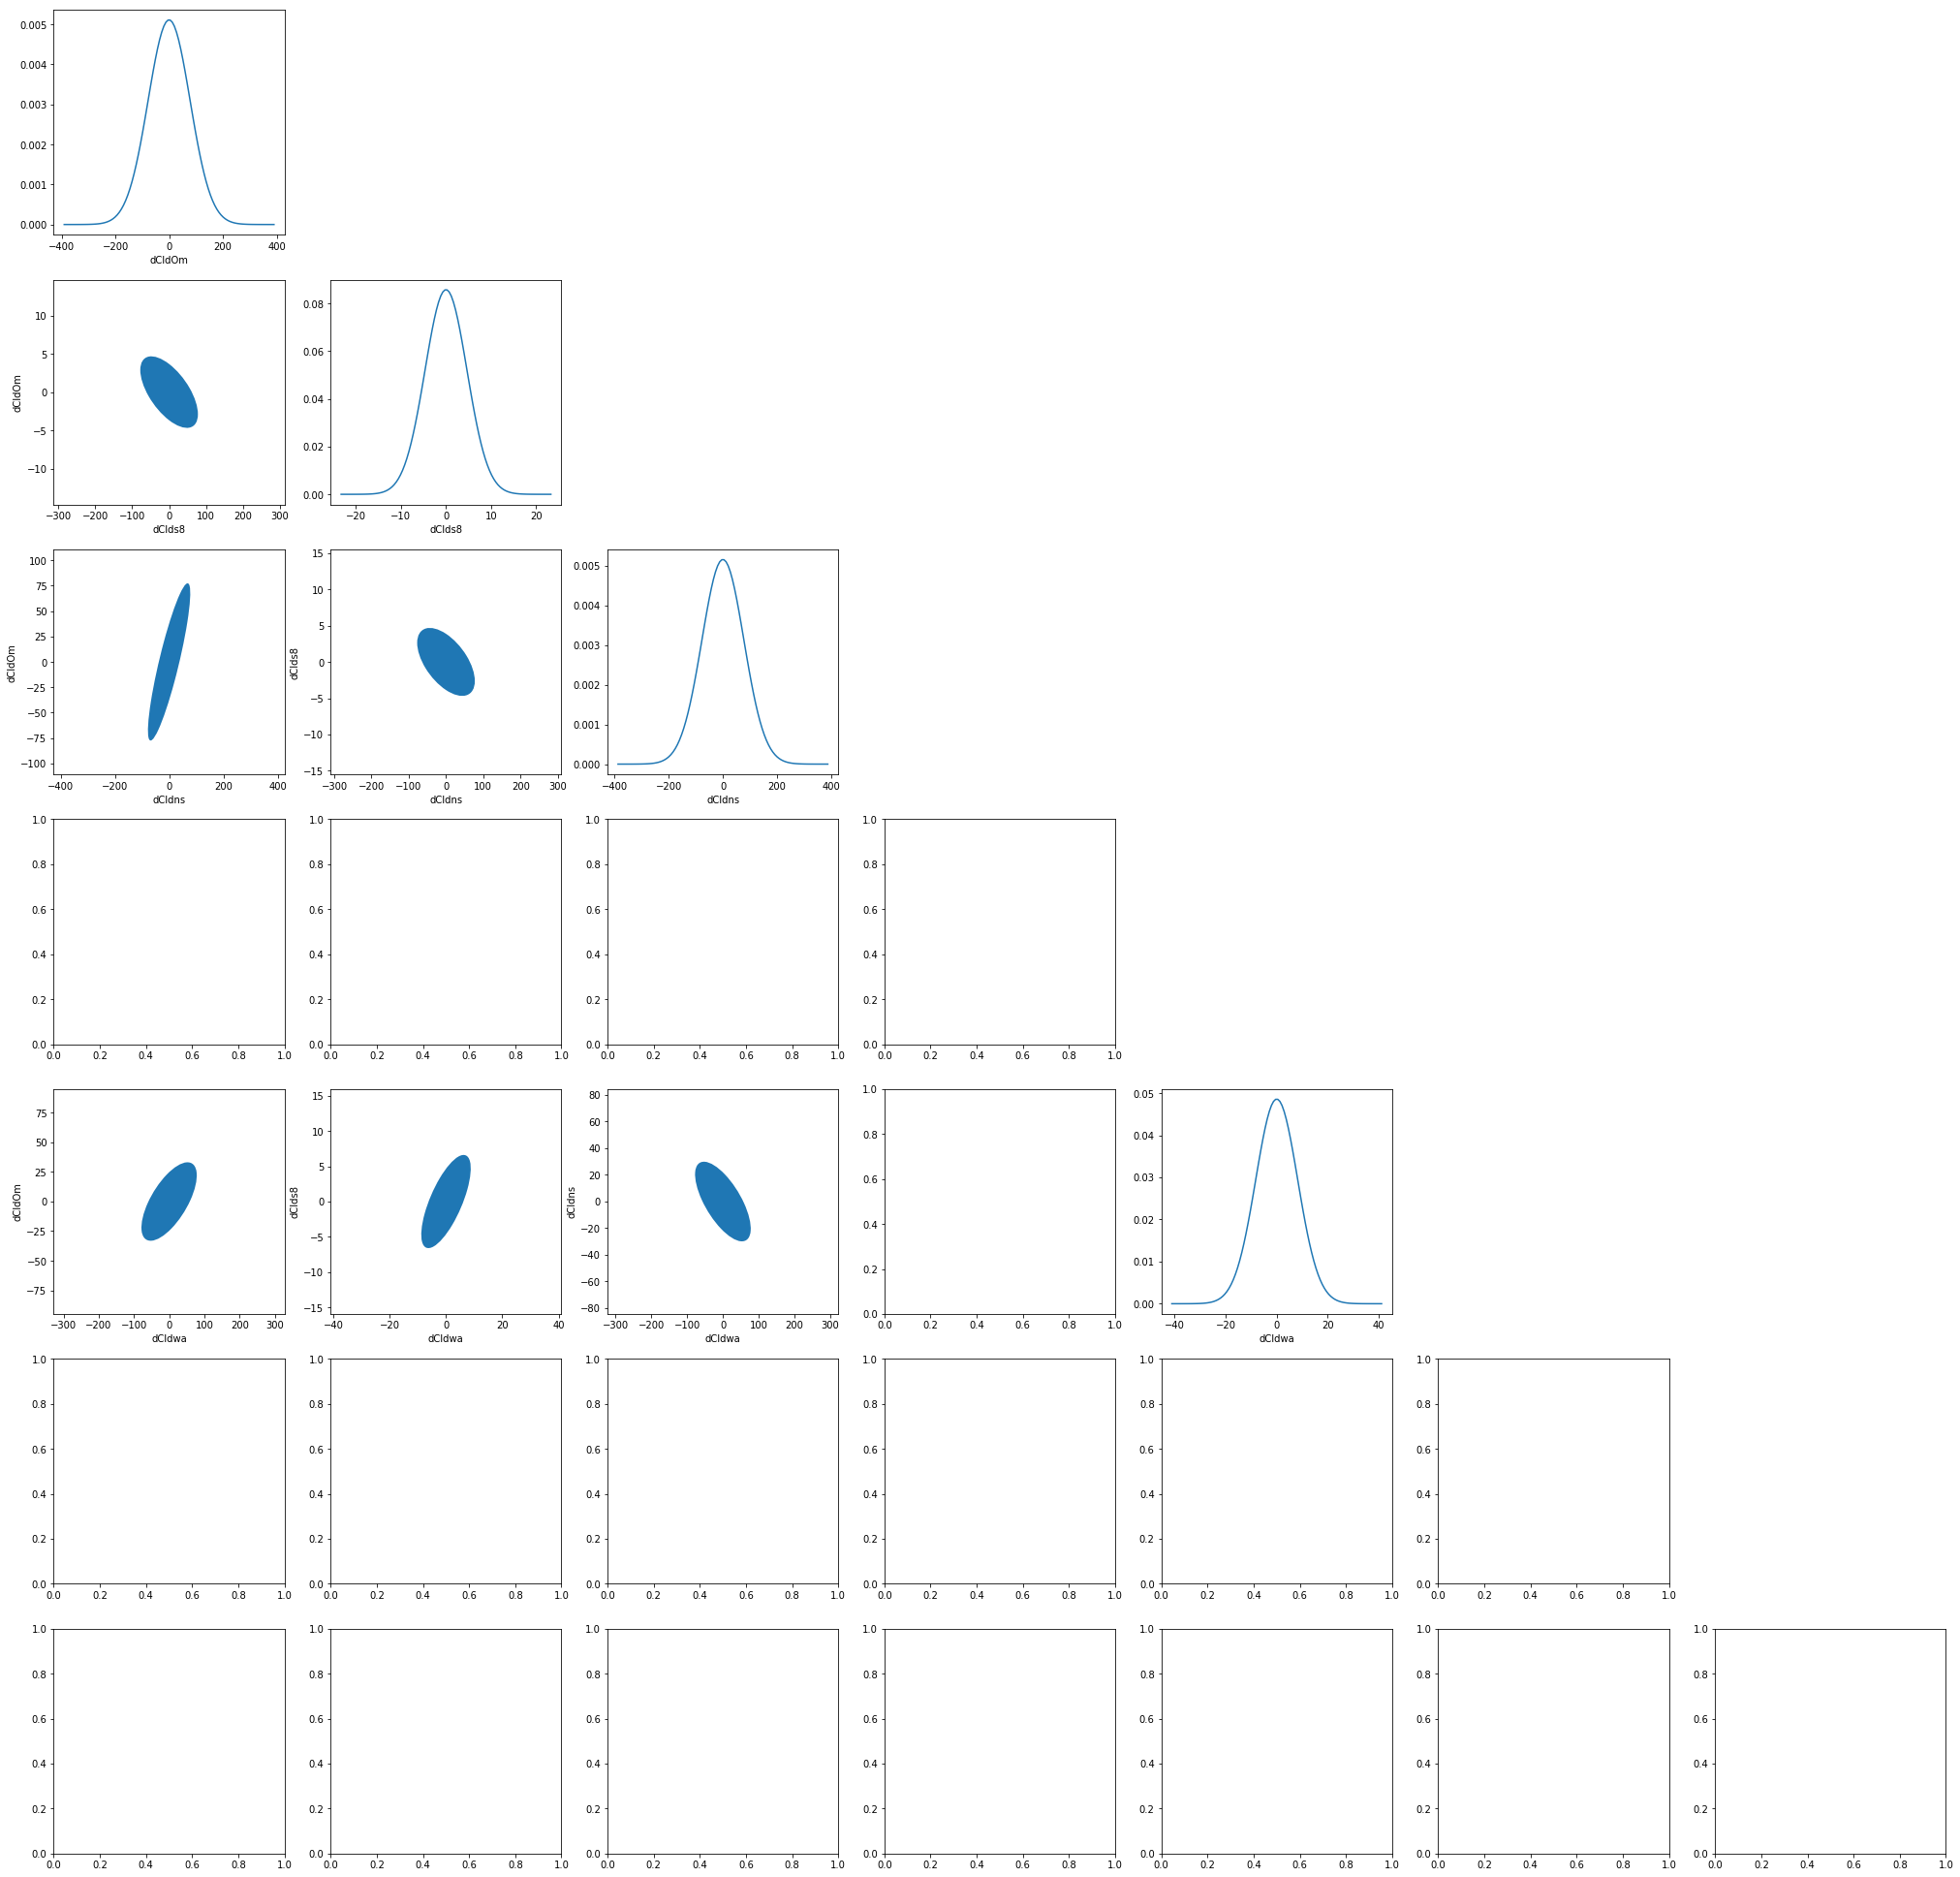

In [33]:
keys = ['dCldOm', 'dClds8', 'dCldns', 'dCldw0', 'dCldwa', 'dCldOb', 'dCldH0']
def mycorner(fisher, keys):
    ncol = len(keys)
    fig = plt.figure(figsize=(ncol*5, ncol*5))
    ax = [[fig.add_subplot(ncol, ncol, ncol * i + j + 1) for j in range(i+1)] for i in range(ncol)]
    to_keep = [0, 1, 2, 4]
    for i in to_keep:#range(ncol):
        for j in to_keep:#range(i+1):
            sxx = fisher[i][i]
            sx = np.sqrt(sxx)
            xlim = (-5.*sx, 5.*sx)
            if i == j:
                x_grid = np.linspace(xlim[0], xlim[-1], 100)
                func = sps.norm(0., np.sqrt(sxx))
                ax[i][j].plot(x_grid, func.pdf(x_grid))
                ax[i][j].set_xlabel(keys[i])
            else:
                syy = fisher[j][j]
                sy = np.sqrt(syy)
                ylim = (-5.*sy, 5.*sy)
                term1 = (sxx + syy)/2.
                term2 = np.sqrt((sxx-syy)**2/4. + fisher[i][j] * fisher[j][i])
                a = np.sqrt(np.abs(term1 + term2))
                b = np.sqrt(np.abs(term1 - term2))
                t = np.arctan((fisher[i][j] + fisher[j][i])/(sxx-syy))/2.
                print((i, j, term1, term2, a, b, t))
                ellipse = Ellipse(xy=(0., 0.), width=2.*a, height=2.*b, angle=t*180./np.pi)
                ax[i][j].add_artist(ellipse)
                ax[i][j].set_xlabel(keys[i])
                ax[i][j].set_ylabel(keys[j])
                ax[i][j].set_xlim(-4.*a, 4.*a)
                ax[i][j].set_ylim(-4.*b, 4.*b)
    return
mycorner(invfisher, keys)

# ancient scratch

In [ ]:
z_0 = 0.3
def smooth_func(z):
    return 1/(2 * z_0) * (z/z_0)**2 * np.exp(-z/z_0)
zs = np.linspace(0., 1., 100)

nz = smooth_func(zs[:-1])
nz /= np.dot(nz, zs[1:]-zs[:-1])
plt.plot(zs[:-1], nz)

In [ ]:
print(np.dot(true_funcs[0].evaluate(grid_mids), true_nz_info['grid'][1:]-true_nz_info['grid'][:-1]))

In [ ]:
print(np.dot(true_funcs[0].distweights, true_funcs[0].dbins))

In [ ]:
func = sps.norm(0.25, 0.05)
print(func.std())
x = np.linspace(0., 1., 100)
plt.plot(x, func.pdf(x))

In [ ]:
n_bins = 100
z_mids = np.linspace(0., 1., n_bins)

a = 1.
b = 20.#mid-scale variations, larger means more peaks
c = 1.e-6#longest-scale variation, lower increases amplitude relative to small-scale
prior_var = np.eye(n_bins)
for k in range(n_bins):
    prior_var[k] = a * np.exp(-0.5 * b * (z_mids[k] - z_mids) ** 2)
prior_var += c * np.identity(n_bins)

prior_mean = np.zeros(n_bins)
prior = chippr.mvn(prior_mean, prior_var)

In [ ]:
samples = prior.sample(7)
for each in samples:
    plt.plot(z_mids, each)